# Padim Example

#### Import dependencies

In [23]:
import anodet
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 

## Training

#### Load dataset

In [24]:
data_path = '../../data/mvtec_dataset/bottle/train/good/' 
dataset = anodet.AnodetDataset(data_path)
dataloader = DataLoader(dataset, batch_size=32, pin_memory=True)
print("Number of images in dataset:", len(dataloader.dataset))

Number of images in dataset: 209


#### Init the model

In [25]:
padim = anodet.Padim(backbone='resnet18')

#### Fit the model to the dataset

In [26]:
padim.fit(dataloader)

Feature extraction: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


#### Save the necessary parameters

In [28]:
distributions_path = '../distributions/'
torch.save(padim.mean, distributions_path+'bottle_mean.pt')
torch.save(padim.cov_inv, distributions_path+'bottle_cov_inv.pt')

# 

## Inference
#### Load test images

In [29]:
paths = [
    '../../data/mvtec_dataset/bottle/test/broken_large/000.png',
    '../../data/mvtec_dataset/bottle/test/broken_small/000.png',
    '../../data/mvtec_dataset/bottle/test/contamination/000.png',
    '../../data/mvtec_dataset/bottle/test/good/000.png',
    '../../data/mvtec_dataset/bottle/test/good/001.png',
]

images = []
for path in paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

batch = anodet.to_batch(images, anodet.standard_image_transform, torch.device('cpu'))

#### Load the necessary parameters

In [30]:
distributions_path = '../distributions/'
mean = torch.load(distributions_path+'bottle_mean.pt')
cov_inv = torch.load(distributions_path+'bottle_cov_inv.pt')

#### init the model

In [31]:
padim = anodet.Padim(backbone='resnet18', mean=mean, cov_inv=cov_inv, device=torch.device('cpu'))

#### Make prediction

In [32]:
image_scores, score_maps = padim.predict(batch)

#### Interpret the prediction

In [33]:
THRESH = 13
score_map_classifications = anodet.classification(score_maps, THRESH)
image_classifications = anodet.classification(image_scores, THRESH)
print("Image scores:", image_scores)
print("Image classifications:", image_classifications)

Image scores: tensor([26.2478, 21.5471, 23.0032, 10.2540,  9.6295])
Image classifications: tensor([0., 0., 0., 1., 1.])


#### Visualization

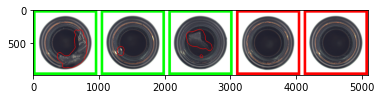

In [34]:
orig_images = np.array(images)
test_images = orig_images


img = anodet.visualization.framed_boundary_images(test_images, score_map_classifications, image_classifications, padding=40)
tot_image = anodet.visualization.merge_images(img, margin=50)
plt.imshow(tot_image)

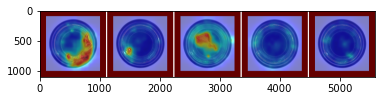

In [35]:
heat_maps = anodet.visualization.heatmap_images(test_images, score_maps, alpha=0.5)
heat_maps = np.array([anodet.visualization.frame_image(m, color=(100, 0, 0), padding=100) for m in heat_maps])
tot_img = anodet.visualization.merge_images(heat_maps, margin=20)
plt.imshow(tot_img)

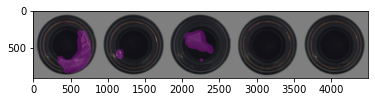

In [36]:
high_lighted = anodet.visualization.highlighted_images(images, score_map_classifications, color=(128, 0, 128))
tot_img = anodet.visualization.merge_images(high_lighted)
plt.imshow(tot_img)

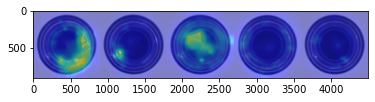

In [39]:
heat_maps = anodet.visualization.heatmap_images(test_images, score_maps, min_v = 0.1, max_v = 40, alpha=0.5)
tot_img = anodet.visualization.merge_images(heat_maps)
plt.imshow(tot_img)